<a href="https://colab.research.google.com/github/peony1217-ctrl/DL/blob/main/DKTC_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DKTC 프로젝트 베이스 코드!

한국어로 이루어진 위협 분류 문제를 해결해봅시다~

메인 문제는 다음과 같습니다

1. 한국어 데이터를 전처리 하는 방법은..?
2. 토큰의 길이는 표준화를 해주는게 좋을까..?
3. 모델에서는 어떤것들을 건드려서 성능을 높일수있을까..?
4. 원본데이터는 어떻게 생겼길래..? 우리가 처리할수있는 부분이있을까?

이런 고민을 기억하시면서 아래 베이스 코드를 쭉 따라가 봅시다

In [1]:
# 한글 폰트 설정은 한번 실행하고 런타임 재시작을 해야합니다
import matplotlib.pyplot as plt
import platform

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# Colab에서 한글 폰트 설치 및 설정
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,854 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr

In [2]:
!pip install konlpy pandas numpy matplotlib seaborn --break-system-packages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 41.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from konlpy.tag import Okt
from collections import Counter
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

# 모델링 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

print(f"TensorFlow version: {tf.__version__}")

# 시드 고정
np.random.seed(42)
tf.random.set_seed(42)

TensorFlow version: 2.19.0


# STEP 1. 데이터 가져오기

- 캐글페이지에서 학습데이터를 가져옵시다~
https://www.kaggle.com/competitions/deep-learning-main-quest-dktc-ds-6/data

- 드라이브에 넣어놓은 데이터를 불러와야겠죠?
- 본인의 경로로 바꿔줍시다 아니면 오류가 나요(이건 제 경로)

In [4]:
import pandas as pd

# 기존 train 데이터 로드
train_data = pd.read_csv('/content/train.csv')

# normal_conversation 데이터 로드
normal_data = pd.read_csv('/content/normal_conversation.csv')

# normal_data에 idx 컬럼 추가 (train_data의 마지막 idx부터 이어서)
normal_data['idx'] = range(train_data['idx'].max() + 1,
                           train_data['idx'].max() + 1 + len(normal_data))

# 컬럼 순서를 train_data와 동일하게 맞추기 (idx, class, conversation)
normal_data = normal_data[['idx', 'class', 'conversation']]

# 두 데이터프레임 합치기
train_data = pd.concat([train_data, normal_data], ignore_index=True)

print("합친 후 데이터 shape:", train_data.shape)
print("\n클래스 분포:")
print(train_data['class'].value_counts())
print("\n처음 5개 행:")
print(train_data.head())
print("\n마지막 5개 행:")
print(train_data.tail())

합친 후 데이터 shape: (5216, 3)

클래스 분포:
class
일반 대화          1266
기타 괴롭힘 대화      1094
갈취 대화           981
직장 내 괴롭힘 대화     979
협박 대화           896
Name: count, dtype: int64

처음 5개 행:
   idx      class                                       conversation
0    0      협박 대화  지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1    1      협박 대화  길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2    2  기타 괴롭힘 대화  너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3    3      갈취 대화  어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4    4      갈취 대화  저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...

마지막 5개 행:
       idx  class                                       conversation
5211  5211  일반 대화  최근에 어떤 앱을 자주 사용해? 나는 운동 기록 앱을 사용하고 있어. 매일 운동극한...
5212  5212  일반 대화  을 사려고 하는데 추천 수 있나요?최근에 출시된 A모델이 좋다고 들었어요.감사합니다...
5213  5213  일반 대화  새 전자제품을 사려고 하는데 추천해주실 수 있나요? 최근에 출시된 A모델이 좋다고 ...
5214  5214  일반 대화  이번 주말에 친구들들신난다함께스릴 에 가기로 했어.타고정말 기대돼!많이놀이기구를 타...
5215  5215  일반 대화  이번 주말에 친구들과 함께 놀이공원에 가기로 했어. 정말 기대

### 전처리!

- 영어와조금은 다른 전처리를 해줘야합니다
- 또 어떤 부분이 다를까요?
- 일단 기본적으로 한국어 영어 특수한 부분은 남기고 없애줍시다
- 긴 공백도 없애줍시다

- 실제 데이터를 살펴보면서 전처리를 해줘야하는것들을 찾아주면 좋습니다

### 토큰화

- 영어는 띄어쓰기를 기준으로 토큰화를 진행합니다
- 한글은 형태소를 기준으로 토큰화를 진행합니다Okt 라는 라이브러리를 이용합니다

In [5]:
# 전처리 함수
def clean_korean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'[^가-힣a-zA-Z0-9\\s.,!?]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# 토큰화 함수
tokenizer_okt = Okt()

def tokenize_korean(text):
    if not isinstance(text, str) or len(text) == 0:
        return []
    try:
        return tokenizer_okt.morphs(text)
    except:
        return []

# 전처리 및 토큰화 적용
print("전처리 및 토큰화 진행 중...")
train_data['cleaned_text'] = train_data['conversation'].apply(clean_korean_text)
train_data['tokens'] = train_data['cleaned_text'].apply(tokenize_korean)
train_data['token_length'] = train_data['tokens'].apply(len)

corpus = train_data['tokens']

print("완료!")

전처리 및 토큰화 진행 중...
완료!


### 토큰화가 어떻게 진행되었는지를 확인해봅시다

In [6]:
train_data

,idx,class,conversation,cleaned_text,tokens,token_length
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가? 아닙니다. 죄송합니다. 죽을 거면 혼...,"[지금, 너, 스스로, 를, 죽여, 달라, 고, 애원, 하는, 것, 인가, ?, 아...",99
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다. 9시 40분 마트에 폭발물을 설치할거다. 네? 똑바로 들어 한번만...,"[길동, 경찰서, 입니다, ., 9시, 40분, 마트, 에, 폭발물, 을, 설치, ...",73
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어. 그만해. 니들 놀리는거 재미없...,"[너, 되게, 귀여운거, 알, 지, ?, 나, 보다, 작은, 남자, 는, 첨, 봤어...",97
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예?? 너 말이야 너. 이리 오라고 무슨 일. 너 옷 좋아보인다? 얘 돈...,"[어이, 거기, 예, ??, 너, 말, 이야, 너, ., 이리, 오라, 고, 무슨,...",48
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,"[저기, 요, 혹시, 날, 이, 너무, 뜨겁잖아요, ?, 저희, 회사, 에서, 이,...",186
...,...,...,...,...,...,...
5211,5211,일반 대화,최근에 어떤 앱을 자주 사용해? 나는 운동 기록 앱을 사용하고 있어. 매일 운동극한...,최근에 어떤 앱을 자주 사용해? 나는 운동 기록 앱을 사용하고 있어. 매일 운동극한...,"[최근, 에, 어떤, 앱, 을, 자주, 사용, 해, ?, 나, 는, 운동, 기록, ...",60
5212,5212,일반 대화,을 사려고 하는데 추천 수 있나요?최근에 출시된 A모델이 좋다고 들었어요.감사합니다...,을 사려고 하는데 추천 수 있나요?최근에 출시된 A모델이 좋다고 들었어요.감사합니다...,"[을, 사려, 고, 하는데, 추천, 수, 있나요, ?, 최근, 에, 출시, 된, A...",55
5213,5213,일반 대화,새 전자제품을 사려고 하는데 추천해주실 수 있나요? 최근에 출시된 A모델이 좋다고 ...,새 전자제품을 사려고 하는데 추천해주실 수 있나요? 최근에 출시된 A모델이 좋다고 ...,"[새, 전자제품, 을, 사려, 고, 하는데, 추천, 해주실, 수, 있나요, ?, 최...",72
5214,5214,일반 대화,이번 주말에 친구들들신난다함께스릴 에 가기로 했어.타고정말 기대돼!많이놀이기구를 타...,이번 주말에 친구들들신난다함께스릴 에 가기로 했어.타고정말 기대돼!많이놀이기구를 타...,"[이번, 주말, 에, 친구, 들들, 신난다, 함께, 스릴, 에, 가기, 로, 했어,...",68


### 시퀀스 길이를 조절해보자

- 너무 긴 시퀀스가 중간중간 섞여있으면 그 친구를 기준으로 전체 길이가 정해짐
- 짧은 문장들은 뒤에가 다 0인채로 모델에 학습됨
- 이는 성능 저하를 불러올수도있기 때문에 조금 잘라냄

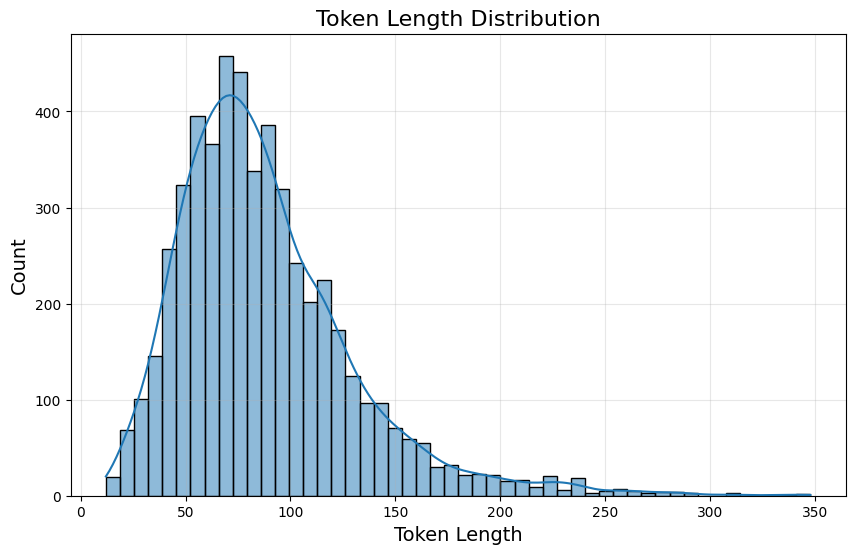

1사분위수 (Q1): 59.0
2사분위수 (Q2, Median): 80.0
3사분위수 (Q3): 109.0
최대 길이: 348


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns

# 1) 히스토그램 시각화
plt.figure(figsize=(10,6))
sns.histplot(train_data['token_length'], bins=50, kde=True)
plt.title("Token Length Distribution", fontsize=16)
plt.xlabel("Token Length", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

# 2) 사분위수 계산
q1 = train_data['token_length'].quantile(0.25)
q2 = train_data['token_length'].quantile(0.50)  # median
q3 = train_data['token_length'].quantile(0.75)
max_len = train_data['token_length'].max()

# 3) 출력
print(f"1사분위수 (Q1): {q1}")
print(f"2사분위수 (Q2, Median): {q2}")
print(f"3사분위수 (Q3): {q3}")
print(f"최대 길이: {max_len}")

### Voca 만들기

- 크기는 10000개 정도로 잡아줍시다
- 크기를 바꾸면서 성능을 보셔도 좋습니다
- 저번에는 영어였고 이번에는 한글 단어장이라 숫자가 달라질수도..?

In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=10000,
        filters=' ',
        oov_token="<unk>"
    )
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post',maxlen=150)

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  40    7 2802 ...    0    0    0]
 [ 447 1796  202 ...    0    0    0]
 [   7  943    1 ...    0    0    0]
 ...
 [ 720 6533   15 ...    0    0    0]
 [  62   99    6 ...    0    0    0]
 [  62   99    6 ...    0    0    0]] <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7ea77ac58d40>


### class 처리 및 분할

- class가 object 타입 즉 '협박' 이런식으로 작성되어있기때문에
- 이를 정수형으로 변환할 필요가있음 (순서주의, 캐글에서는 제출숫자와 자동 매핑 숫자를 구분해야함)
- 이후 적당한 퍼센트를 val, test로 나눔
- 각 라벨별 비율이 극단적으로 나뉘지는 않았는지를 확인

In [ ]:
from sklearn.preprocessing import LabelEncoder

X = tensor


# 각 클래스를 숫자로 매핑
label_map = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화': 4
}

y = train_data['class'].map(label_map)

y = np.array(y)

print("X shape:", X.shape)  # (num_samples, 150)
print("y shape:", y.shape)  # (num_samples,)


X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42,
    stratify=y
)

print("데이터셋 분할:")
print(f"Train set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")

# 4) 클래스 분포 확인
print("\n클래스 분포:")
print("Train:", np.bincount(y_train))
print("Validation:", np.bincount(y_val))

X shape: (5216, 150)
y shape: (5216,)
데이터셋 분할:
Train set: 4433 samples (85.0%)
Validation set: 783 samples (15.0%)

클래스 분포:
Train: [ 761  834  832  930 1076]
Validation: [135 147 147 164 190]


# Step ?. 모델 만들기

시퀀스 형태의 자연어 문장을 처리하기위해 LSTM을 사용해봅시다!
- 임베딩은 layer로 대체하고
- 일반 LSTM보다 성능이 좋다고 하는 Bi directional한 모델을 베이스로 드렸습니다
- 2번의 LSTM이후 Dense 레이어가 있습니다
- 마지막은 다중분류다보니 softmax로 끝내야합니다


- 여기서 바꿀수있는 부분은 뭘까요? 여러가지를 바꿔보면서 실험해보세요

In [ ]:
def build_lstm_model(vocab_size, embedding_dim, max_length, num_classes):
    """
    LSTM 기반 텍스트 분류 모델

    Args:
        vocab_size (int): 어휘 크기
        embedding_dim (int): 임베딩 차원
        max_length (int): 최대 시퀀스 길이
        num_classes (int): 클래스 수

    Returns:
        keras.Model: 컴파일된 모델
    """
    model = keras.Sequential([
        layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            input_length=max_length,
            mask_zero=True,
            name='embedding'
        ),

        layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),

        layers.Dense(num_classes, activation='softmax', name='output')
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# 하이퍼파라미터 설정
VOCAB_SIZE = tokenizer.num_words
EMBEDDING_DIM = 128
MAX_LENGTH = 150
NUM_CLASSES = len(np.unique(y))

print("모델 하이퍼파라미터:")
print(f"Vocab Size: {VOCAB_SIZE}")
print(f"Embedding Dim: {EMBEDDING_DIM}")
print(f"Max Length: {MAX_LENGTH}")
print(f"Num Classes: {NUM_CLASSES}")

모델 하이퍼파라미터:
Vocab Size: 10000
Embedding Dim: 128
Max Length: 150
Num Classes: 5


In [ ]:
model = build_lstm_model(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH, NUM_CLASSES)
print("LSTM 모델 생성 완료")

LSTM 모델 생성 완료


In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [ ]:
# 모델 학습
BATCH_SIZE = 32
EPOCHS = 30

print("모델 학습 시작...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
print("학습 완료!")

모델 학습 시작...
Epoch 1/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.4041 - loss: 1.2864 - val_accuracy: 0.7382 - val_loss: 0.5864 - learning_rate: 0.0010
Epoch 2/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8173 - loss: 0.4714 - val_accuracy: 0.8314 - val_loss: 0.5356 - learning_rate: 0.0010
Epoch 3/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9340 - loss: 0.1990 - val_accuracy: 0.8084 - val_loss: 0.7258 - learning_rate: 0.0010
Epoch 4/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9563 - loss: 0.1482 - val_accuracy: 0.8506 - val_loss: 0.5812 - learning_rate: 0.0010
Epoch 5/30
137/139 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9765 - loss: 0.0840
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9767 - loss: 0.0837 - val_accuracy: 0.8697 - val_loss: 0.5647 - learning_rate: 0.0010
Epoch 6/30
139/139 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.996

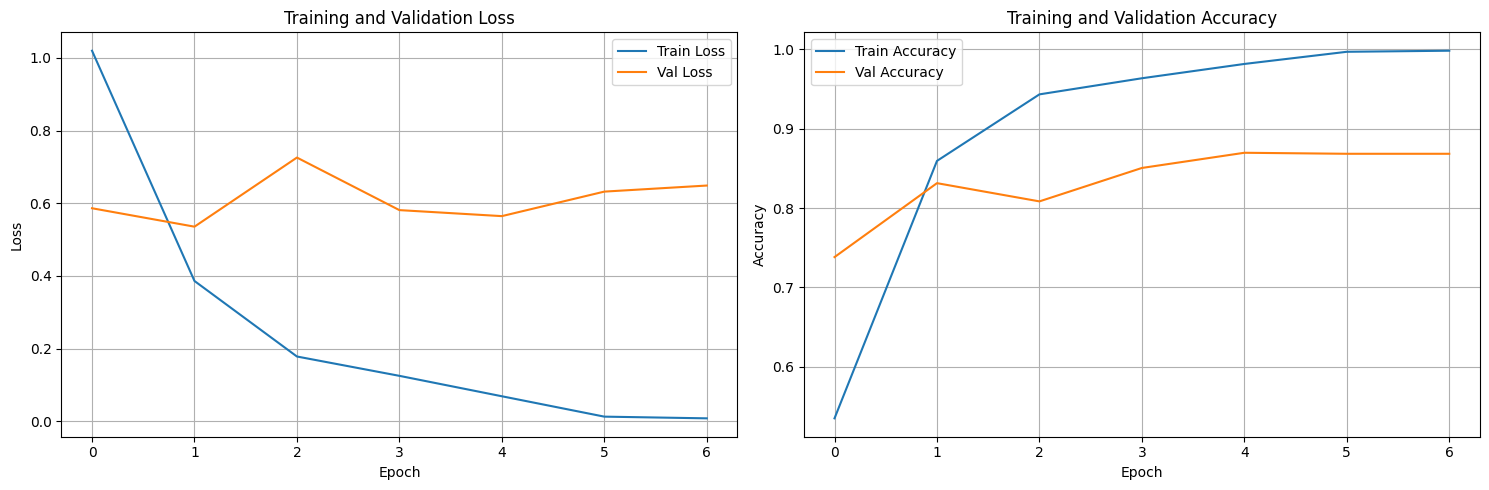

In [ ]:
# 학습 곡선 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss')
axes[0].plot(history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy')
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def predict_text(text, model, tokenizer, max_length, class_names):
    """
    새로운 텍스트 예측

    Args:
        text (str): 예측할 텍스트
        model: 학습된 모델
        vocab_builder: 어휘 사전
        max_length (int): 최대 시퀀스 길이
        class_names (list): 클래스 이름 리스트

    Returns:
        dict: 예측 결과
    """
    # 전처리
    cleaned = clean_korean_text(text)
    tokens = tokenize_korean(cleaned)

    # 인덱스 변환
    seq = tokenizer.texts_to_sequences([' '.join(tokens)])

    # 패딩
    padded = pad_sequences(
        seq,
        maxlen=max_length,     # 예: 150
        padding='post',
        truncating='post'
        # value 생략 시 0이 패딩 토큰 (기본값)
    )
   # 예측
    pred_proba = model.predict(padded, verbose=0)[0]
    pred_class = np.argmax(pred_proba)

    return {
        'text': text,
        'cleaned_text': cleaned,
        'tokens': tokens,  # 위에서 만든 토큰 리스트
        'predicted_class': class_names[pred_class],
        'confidence': float(pred_proba[pred_class]),
        'probabilities': {
            class_names[i]: float(prob) for i, prob in enumerate(pred_proba)
        }
    }

In [ ]:
# 예측 테스트
test_texts = [
    "말 안들으면 혼날 줄 알아",
    "돈 내놔 안그러면 큰일난다",
    "또 실수했어? 정말 못쓰겠네",
    "넌 정말 쓸모없는 인간이야"
]

class_names = [
    '협박',
    '갈취',
    '직장내괴롭힘',
    '기타 괴롭힘',
    '일반'
]

print("=" * 80)
print("예측 테스트")
print("=" * 80)

max_length = 150

for i, text in enumerate(test_texts, 1):
    result = predict_text(text, model, tokenizer, max_length, class_names)

    print(f"\n[테스트 {i}]")
    print(f"입력: {result['text']}")
    print(f"예측: {result['predicted_class']} (신뢰도: {result['confidence']:.4f})")
    print("확률:")
    for class_name, prob in result['probabilities'].items():
        print(f"  {class_name}: {prob:.4f}")

예측 테스트

[테스트 1]
입력: 말 안들으면 혼날 줄 알아
예측: 기타 괴롭힘 (신뢰도: 0.6350)
확률:
  협박: 0.2413
  갈취: 0.0837
  직장내괴롭힘: 0.0246
  기타 괴롭힘: 0.6350
  일반: 0.0154

[테스트 2]
입력: 돈 내놔 안그러면 큰일난다
예측: 갈취 (신뢰도: 0.7466)
확률:
  협박: 0.1504
  갈취: 0.7466
  직장내괴롭힘: 0.0301
  기타 괴롭힘: 0.0695
  일반: 0.0034

[테스트 3]
입력: 또 실수했어? 정말 못쓰겠네
예측: 일반 (신뢰도: 0.6909)
확률:
  협박: 0.0440
  갈취: 0.0485
  직장내괴롭힘: 0.1462
  기타 괴롭힘: 0.0704
  일반: 0.6909

[테스트 4]
입력: 넌 정말 쓸모없는 인간이야
예측: 직장내괴롭힘 (신뢰도: 0.4319)
확률:
  협박: 0.1067
  갈취: 0.0973
  직장내괴롭힘: 0.4319
  기타 괴롭힘: 0.0949
  일반: 0.2691


# 캐글 제출용 코드

- test데이터셋을 불러와서 idx를 넣는다
- submission.csv로 저장한다


In [ ]:
test_data_path = "/content/drive/MyDrive/Colab Notebooks/데싸/데싸6기/Data/DKTC/test.json"

submission_data_path = "/content/drive/MyDrive/Colab Notebooks/데싸/데싸6기/Data/DKTC/submission.csv"

In [ ]:
# 2. test.json 불러오기
with open(test_data_path, "r", encoding="utf-8") as f:
    test_data = json.load(f)

submission = pd.read_csv(submission_data_path)

# id 기준 정렬(혹시나 섞여 있을 수 있으니)
submission = submission.sort_values("idx").reset_index(drop=True)

# submission의 id 순서에 맞춰서 test_data에서 text 가져오기
ids = submission["idx"].tolist()                 # 예: ['t_000', 't_001', ...]
texts = [test_data[i]["text"] for i in ids]

In [ ]:
len(texts)

500

In [ ]:
# -------------------------------------------------
# 4. Tokenizer로 시퀀스 변환 + 패딩
#    (tokenizer는 이미 train에서 fit_on_texts(corpus) 된 상태라고 가정)
# -------------------------------------------------
sequences = tokenizer.texts_to_sequences(texts)

In [ ]:
X_test = pad_sequences(
    sequences,
    maxlen=max_length,
    padding='post',
    truncating='post'
)

In [ ]:
pred_proba = model.predict(X_test, batch_size=32, verbose=1)
pred_indices = np.argmax(pred_proba, axis=1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [ ]:
pred_labels = pred_indices
pred_labels

array([0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 2, 2, 0, 0, 2, 3, 0, 3, 0, 3,
       3, 1, 1, 2, 3, 3, 2, 0, 0, 0, 1, 0, 3, 3, 0, 0, 0, 0, 0, 1, 2, 0,
       2, 2, 0, 0, 3, 0, 1, 0, 2, 2, 2, 0, 3, 2, 3, 2, 1, 2, 2, 2, 2, 0,
       0, 3, 2, 2, 1, 2, 3, 2, 0, 2, 0, 2, 2, 2, 1, 0, 0, 2, 2, 2, 3, 3,
       1, 2, 2, 2, 0, 3, 2, 2, 2, 2, 0, 2, 3, 1, 2, 0, 2, 2, 2, 2, 2, 0,
       0, 3, 0, 2, 3, 0, 0, 2, 2, 0, 0, 3, 1, 1, 1, 1, 2, 2, 1, 3, 0, 3,
       2, 3, 1, 0, 0, 2, 3, 2, 3, 3, 1, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 2,
       2, 3, 0, 2, 3, 0, 2, 3, 2, 0, 2, 2, 2, 3, 3, 1, 0, 2, 0, 2, 0, 3,
       0, 0, 0, 3, 2, 3, 2, 2, 0, 2, 0, 0, 0, 0, 0, 3, 1, 0, 0, 0, 3, 2,
       0, 0, 2, 0, 2, 2, 0, 3, 2, 2, 0, 2, 0, 2, 0, 2, 0, 3, 3, 0, 0, 3,
       0, 2, 2, 0, 0, 1, 2, 2, 0, 0, 2, 2, 3, 3, 1, 3, 0, 0, 0, 0, 3, 2,
       0, 2, 2, 1, 2, 1, 2, 2, 0, 2, 0, 2, 0, 3, 0, 2, 1, 2, 1, 3, 0, 0,
       0, 2, 3, 2, 2, 3, 0, 2, 0, 2, 3, 0, 2, 0, 2, 2, 1, 0, 3, 2, 2, 2,
       0, 2, 1, 3, 0, 1, 0, 3, 2, 0, 0, 0, 1, 3, 2,

In [ ]:
submission["target"] = pred_labels

In [ ]:
submission

,idx,target
0,t_000,0
1,t_001,2
2,t_002,2
3,t_003,2
4,t_004,0
...,...,...
495,t_495,2
496,t_496,0
497,t_497,1
498,t_498,2


In [ ]:
save_path = "/content/drive/MyDrive/Colab Notebooks/데싸/데싸6기/Data/DKTC/my_submission.csv"
submission.to_csv(save_path, index=False)

print("저장 완료:", save_path)
submission.head()

저장 완료: /content/drive/MyDrive/Colab Notebooks/데싸/데싸6기/Data/DKTC/my_submission.csv


,idx,target
0,t_000,0
1,t_001,2
2,t_002,2
3,t_003,2
4,t_004,0


# 잘 맞춘건가.. 테스트가 어떻게 나왔나 확인코드

In [ ]:
import pandas as pd

rows = []

for tid in sorted(test_data.keys()):
    text = test_data[tid]["text"]
    result = predict_text(text, model, tokenizer, max_length, class_names)

    rows.append({
        "id": tid,
        "text": text,
        "predicted_class": result["predicted_class"],
        "confidence": float(result["confidence"])
    })

test_pred_df = pd.DataFrame(rows)
test_pred_df.head()

,id,text,predicted_class,confidence
0,t_000,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,일반,0.524092
1,t_001,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,기타 괴롭힘,0.977874
2,t_002,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,갈취,0.796802
3,t_003,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,갈취,0.794639
4,t_004,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,갈취,0.816294


# 개선 코드

## 환경 설정 및 라이브러리 설치

In [5]:
# --- 1. 필수 라이브러리 설치 (KC-BERT 사용) ---
!pip install pandas numpy scikit-learn torch transformers matplotlib seaborn nlpaug

# 한글 폰트 설정 (시각화를 위함)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

# 런타임 재시작을 유도하는 출력
print("--- 설치 완료 ---")
print("!!! 중요: 이 셀 실행 후, 런타임을 재시작(Restart Runtime)하세요. !!!")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

## 라이브러리 Import 및 환경 설정

In [4]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report

# 시각화 라이브러리 및 한글 폰트 설정
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# BERT 모델 관련 라이브러리 (Hugging Face 표준 사용)
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW # AdamW를 torch.optim에서 직접 가져오도록 수정

# 데이터 증강 라이브러리
import nlpaug.augmenter.word as naw

# KC-BERT 모델 경로 설정
MODEL_NAME = 'beomi/kcbert-base'

# 설정 (F1-Score 최적화를 위한 하이퍼파라미터 조정)
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 5
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 장치 (Device): {DEVICE}")

사용 장치 (Device): cuda


## 데이터 로드, 시각화 및 증강 (KC-BERT 기반)

--- 데이터 로드 및 통합 시작 ---
--- 클래스 불균형 시각화 ---


/tmp/ipython-input-1779552679.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='class', data=df_train_vis, palette='viridis', order=df_train_vis['class'].value_counts().index)


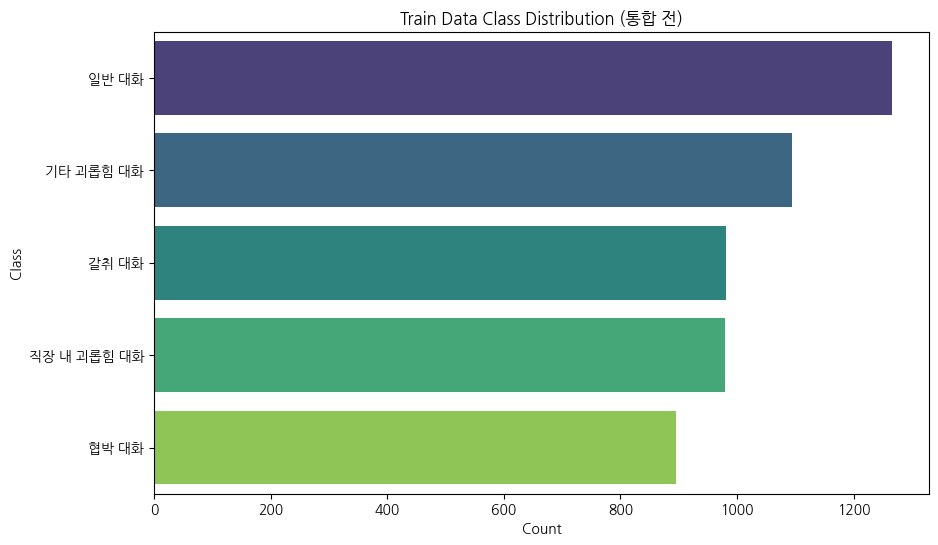


--- 데이터 증강 (Augmentation) 시작 ---


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

The following layers were not sharded: bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.intermediate.dense.weight, cls.predictions.decoder.bias, bert.encoder.layer.*.attention.self.value.bias, cls.predictions.decoder.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.bias, cls.predictions.transform.LayerNorm.weight, cls.predictions.transform.LayerNorm.bias, bert.encoder.layer.*.attention.self.key.bias, bert.embeddings.token_type_embeddings.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.output.LayerNorm.weight, cls.predictions.transform.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.output.LayerNorm.b

클래스 '협박 대화' : 원본 896개, 증강 448개
클래스 '기타 괴롭힘 대화' : 원본 1094개, 증강 547개
클래스 '갈취 대화' : 원본 981개, 증강 490개
클래스 '직장 내 괴롭힘 대화' : 원본 979개, 증강 489개

최종 훈련 데이터 크기 (증강 포함): 7190


In [8]:
# --- 3-1. 데이터 로드 및 통합 ---
print("--- 데이터 로드 및 통합 시작 ---")

df_train_threat = pd.read_csv('train.csv')[['conversation', 'class']]
df_train_threat.columns = ['text', 'class']

df_train_normal = pd.read_csv('normal_conversation.csv')
df_train_normal.columns = ['text', 'class']

df_test = pd.read_csv('test.csv')
df_submission = pd.read_csv('submission.csv')

# --- 3-2. 클래스 분포 시각화 ---
print("--- 클래스 불균형 시각화 ---")
df_train_vis = pd.concat([df_train_threat, df_train_normal], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.countplot(y='class', data=df_train_vis, palette='viridis', order=df_train_vis['class'].value_counts().index)
plt.title('Train Data Class Distribution (통합 전)')
plt.xlabel('Count')
plt.ylabel('Class')
plt.show() #


# --- 3-3. 데이터 증강 (Augmentation) ---
print("\n--- 데이터 증강 (Augmentation) 시작 ---")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Word Embedding Augmenter 정의 (KC-BERT 기반) -> ContextualWordEmbsAug로 변경
aug = naw.ContextualWordEmbsAug(
    model_path=MODEL_NAME,
    action="substitute",
    device=DEVICE.type,
    aug_min=1,
    aug_max=3
)

AUGMENTATION_RATIO = 0.5
augmented_data = []

# 위협 4개 클래스에 대해서만 증강 적용
for cls_name in df_train_threat['class'].unique():
    subset = df_train_threat[df_train_threat['class'] == cls_name]
    num_augment = int(len(subset) * AUGMENTATION_RATIO)
    samples_to_augment = subset.sample(n=num_augment, replace=False, random_state=42)

    print(f"클래스 '{cls_name}' : 원본 {len(subset)}개, 증강 {num_augment}개")

    for text in samples_to_augment['text']:
        augmented_text = aug.augment(text)
        augmented_data.append([augmented_text[0] if isinstance(augmented_text, list) else augmented_text, cls_name])

df_augmented = pd.DataFrame(augmented_data, columns=['text', 'class'])
df_train = pd.concat([df_train_vis, df_augmented], ignore_index=True)

# 라벨 인코딩 및 최종 크기 확인
le = LabelEncoder()
df_train['label'] = le.fit_transform(df_train['class'])

NUM_CLASSES = len(le.classes_)
class_names = le.classes_
print(f"\n최종 훈련 데이터 크기 (증강 포함): {len(df_train)}")

## 모델 정의, DataLoader 및 Optimizer 설정

In [9]:
# --- 4-1. 데이터셋 클래스 정의 및 DataLoader 생성 ---
class BertDataset(Dataset):
    def __init__(self, df, tokenizer, max_len, is_test=False):
        self.texts = df['text'].tolist()
        self.labels = df['label'].tolist() if 'label' in df.columns else None
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_test = is_test

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten()
        }

        if not self.is_test:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

# 학습/검증 데이터 분리
df_train_split, df_val_split = train_test_split(
    df_train, test_size=0.1, random_state=42, stratify=df_train['label']
)

# DataLoader 생성
train_dataset = BertDataset(df_train_split, tokenizer, MAX_LEN)
val_dataset = BertDataset(df_val_split, tokenizer, MAX_LEN)
test_dataset = BertDataset(df_test.rename(columns={'text': 'text'}).assign(label=0), tokenizer, MAX_LEN, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 4-2. 모델 정의 및 Optimizer/Scheduler 설정 ---
class KCBERTClassifier(torch.nn.Module):
    def __init__(self, num_classes):
        super(KCBERTClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(MODEL_NAME)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        pooled_output = outputs[0][:, 0, :] # [CLS] 토큰의 출력 사용
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

model = KCBERTClassifier(NUM_CLASSES).to(DEVICE)

# 옵티마이저 (AdamW + Weight Decay)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
# 스케줄러 (Warmup 적용)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * WARMUP_RATIO),
    num_training_steps=total_steps
)
loss_fn = torch.nn.CrossEntropyLoss()

The following layers were not sharded: encoder.layer.*.attention.self.key.bias, encoder.layer.*.output.LayerNorm.weight, encoder.layer.*.attention.output.dense.bias, encoder.layer.*.attention.output.LayerNorm.bias, encoder.layer.*.attention.self.value.weight, pooler.dense.weight, encoder.layer.*.attention.self.value.bias, embeddings.token_type_embeddings.weight, encoder.layer.*.intermediate.dense.bias, encoder.layer.*.output.dense.bias, embeddings.LayerNorm.weight, encoder.layer.*.attention.output.dense.weight, encoder.layer.*.intermediate.dense.weight, encoder.layer.*.attention.self.key.weight, embeddings.LayerNorm.bias, embeddings.position_embeddings.weight, embeddings.word_embeddings.weight, encoder.layer.*.attention.output.LayerNorm.weight, encoder.layer.*.output.dense.weight, encoder.layer.*.output.LayerNorm.bias, encoder.layer.*.attention.self.query.bias, pooler.dense.bias, encoder.layer.*.attention.self.query.weight


## 학습 루프 및 최적 모델 저장



--- 모델 학습 시작 (Weighted F1-Score 최적화) ---

======== Epoch 1/5 ========
Epoch 1/5203/203 ━━━━━━━━━━━━━━━━━━━━ - loss: 0.1732 - accuracy: 0.9436 - val_loss: 0.1824 - val_accuracy: 0.9485 - val_f1: 0.9482 - learning_rate: 1.4092e-05
-> Best model saved at Epoch 1 with F1-Score: 0.9482

======== Epoch 2/5 ========
Epoch 2/5203/203 ━━━━━━━━━━━━━━━━━━━━ - loss: 0.0518 - accuracy: 0.9847 - val_loss: 0.1975 - val_accuracy: 0.9527 - val_f1: 0.9526 - learning_rate: 9.6499e-06
-> Best model saved at Epoch 2 with F1-Score: 0.9526

======== Epoch 3/5 ========
Epoch 3/5203/203 ━━━━━━━━━━━━━━━━━━━━ - loss: 0.0121 - accuracy: 0.9971 - val_loss: 0.2372 - val_accuracy: 0.9527 - val_f1: 0.9525 - learning_rate: 5.2079e-06

======== Epoch 4/5 ========
Epoch 4/5203/203 ━━━━━━━━━━━━━━━━━━━━ - loss: 0.0048 - accuracy: 0.9991 - val_loss: 0.2141 - val_accuracy: 0.9583 - val_f1: 0.9582 - learning_rate: 7.6586e-07
-> Best model saved at Epoch 4 with F1-Score: 0.9582

======== Epoch 5/5 ========
Epoch 5/5203/203 ━

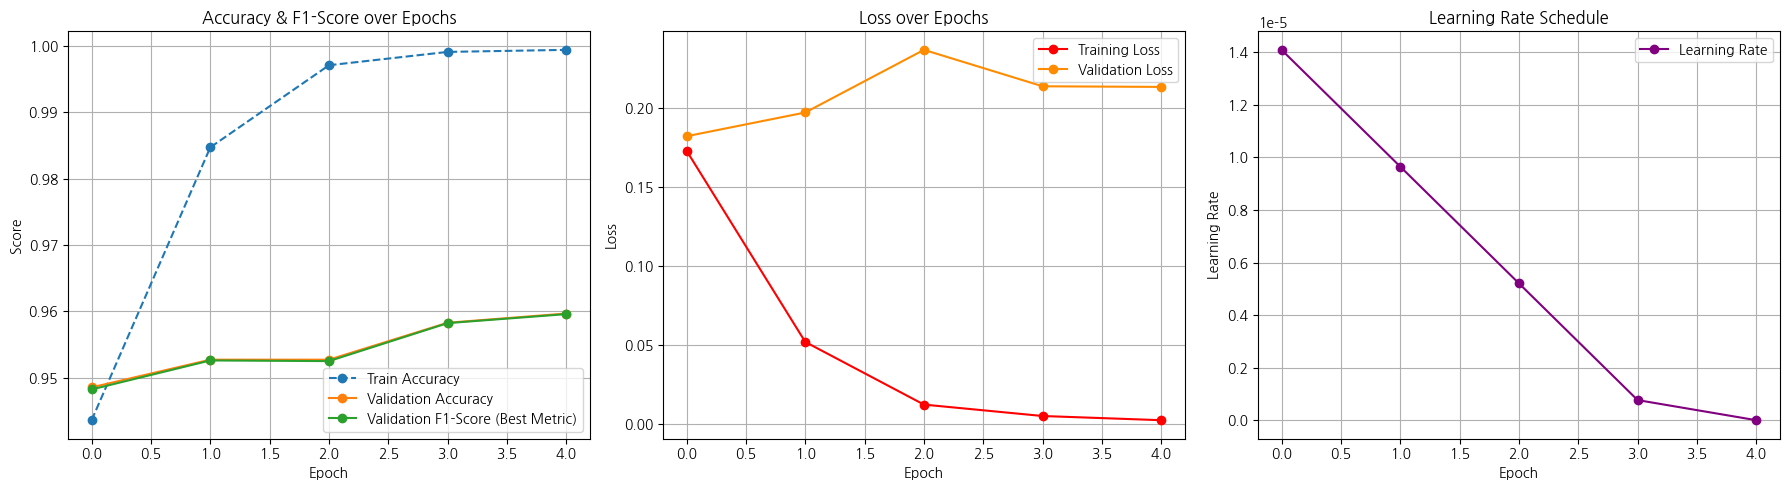


[알림] Epoch별 훈련/검증 결과 시각화 완료.


In [11]:
# --- 5-1. 학습 및 평가 함수 정의 (Keras Output Style에 맞게 수정) ---
# 기존의 train_epoch 함수를 수정하여 epoch당 최종 loss와 accuracy를 계산합니다.

def train_epoch(model, data_loader, loss_fn, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for step, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        loss = loss_fn(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item()

    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / len(data_loader.dataset)
    return avg_loss, avg_accuracy

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    avg_loss = total_loss / len(data_loader)
    avg_accuracy = correct_predictions / len(data_loader.dataset)

    return f1, avg_loss, avg_accuracy, all_labels, all_preds

# --- 5-2. 모델 학습 실행 (Early Stopping 및 시각화 로직 포함) ---
print("\n--- 모델 학습 시작 (Weighted F1-Score 최적화) ---")
best_f1 = 0
best_epoch = -1
patience = 3 # Early Stopping을 위한 patience 설정
patience_counter = 0

# 학습 과정 기록을 위한 리스트 초기화
history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_f1': [],
    'val_accuracy': [],
    'lr': []
}

# 학습 시작 전, 최적 모델 저장을 위해 현재 모델의 초기 상태 저장 (Best Model Restoration을 위함)
initial_model_state = model.state_dict()
torch.save(initial_model_state, 'initial_kcbert_model.bin')


for epoch in range(EPOCHS):
    print(f"\n======== Epoch {epoch + 1}/{EPOCHS} ========")

    # 훈련
    train_loss, train_accuracy = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        scheduler,
        DEVICE
    )

    # 검증 및 F1-Score 계산
    val_f1, val_loss, val_accuracy, _, _ = eval_model(
        model,
        val_loader,
        loss_fn,
        DEVICE
    )

    current_lr = scheduler.get_last_lr()[0]

    # 학습 기록 저장
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)
    history['val_accuracy'].append(val_accuracy)
    history['lr'].append(current_lr)

    # Keras 스타일 출력 시뮬레이션
    print(
        f"Epoch {epoch + 1}/{EPOCHS}"
        f"{len(train_loader)}/{len(train_loader)} ━━━━━━━━━━━━━━━━━━━━ " # Progress bar 시뮬레이션
        f"- loss: {train_loss:.4f} "
        f"- accuracy: {train_accuracy:.4f} "
        f"- val_loss: {val_loss:.4f} "
        f"- val_accuracy: {val_accuracy:.4f} "
        f"- val_f1: {val_f1:.4f} "
        f"- learning_rate: {current_lr:.4e}"
    )

    # Early Stopping 및 모델 체크포인팅 로직 (F1-Score 기준)
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = epoch + 1
        patience_counter = 0 # 개선이 있었으므로 카운터 초기화
        # F1-Score 최적 모델 저장 (모델 체크포인팅)
        torch.save(model.state_dict(), 'best_kcbert_f1_classifier.bin')
        print(f"-> Best model saved at Epoch {best_epoch} with F1-Score: {best_f1:.4f}")
    else:
        patience_counter += 1 # 개선이 없으므로 카운터 증가

        if patience_counter >= patience:
            print(f"\nEpoch {epoch + 1}: early stopping")
            break # 학습 중단

# --- 5-3. 최적 모델 복원 및 학습 완료 출력 ---
if best_epoch != -1:
    # 가장 성능이 좋았던 시점의 모델 가중치 복원
    model.load_state_dict(torch.load('best_kcbert_f1_classifier.bin'))
    print(f"Restoring model weights from the end of the best epoch: {best_epoch}.")
else:
    # Early stopping 없이 끝난 경우, 마지막 에폭의 모델을 사용합니다.
    pass

print("학습 완료!")

# --- 5-4. 학습 결과 시각화 ---
epochs_range = range(len(history['train_loss']))

plt.figure(figsize=(18, 5))

# Plot 1: Accuracy & F1-Score
plt.subplot(1, 3, 1)
plt.plot(epochs_range, history['train_accuracy'], label='Train Accuracy', marker='o', linestyle='--')
plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.plot(epochs_range, history['val_f1'], label='Validation F1-Score (Best Metric)', marker='o')
plt.title('Accuracy & F1-Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)


# Plot 2: Loss
plt.subplot(1, 3, 2)
plt.plot(epochs_range, history['train_loss'], label='Training Loss', marker='o', color='r')
plt.plot(epochs_range, history['val_loss'], label='Validation Loss', marker='o', color='darkorange')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


# Plot 3: Learning Rate
plt.subplot(1, 3, 3)
plt.plot(epochs_range, history['lr'], label='Learning Rate', marker='o', color='purple')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()
print("\n[알림] Epoch별 훈련/검증 결과 시각화 완료.")

## 테스트 데이터 추론 및 최종 제출 파일 생성 (Classification Report 시각화 추가)

In [ ]:
# --- 6. 테스트 데이터 추론 및 제출 파일 생성 ---
print("\n--- 테스트 데이터 추론 및 제출 파일 생성 시작 ---")

# ... (get_test_predictions 함수 정의는 그대로 유지) ...

# 테스트 데이터에 대한 예측 수행
test_preds = get_test_predictions(model, test_loader, DEVICE)

# 제출 파일 생성
df_submission['target'] = test_preds

# Submission 파일 저장
SUBMISSION_FILE_NAME = 'submission_kcbert_optimized.csv'
df_submission.to_csv(SUBMISSION_FILE_NAME, index=False)
print(f"\n✅ 제출 파일 ({SUBMISSION_FILE_NAME}) 생성 완료!")

# 최종 검증 결과 보고
final_f1, val_labels, val_preds = eval_model(model, val_loader, DEVICE)
report = classification_report(val_labels, val_preds, target_names=class_names, zero_division=0, output_dict=True)

print("\n--- 최종 검증 결과 (Classification Report) ---")
print(classification_report(val_labels, val_preds, target_names=class_names, zero_division=0))

# --- 6-2. 클래스별 F1-Score 시각화 (추가) ---
df_report = pd.DataFrame(report).transpose().iloc[:-3] # macro avg, weighted avg, accuracy 제외
df_report['f1-score'] = pd.to_numeric(df_report['f1-score'])

plt.figure(figsize=(10, 6))
sns.barplot(y=df_report.index, x='f1-score', data=df_report.sort_values(by='f1-score', ascending=False), palette='magma')
plt.title('Final Validation F1-Score per Class')
plt.xlabel('F1-Score')
plt.ylabel('Class')
plt.show() #
print("\n[알림] 최종 모델의 클래스별 F1-Score 시각화 완료.")